In [2]:
import os
import json
import shutil
import tempfile
import time

import cv2

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    CropForegroundd, 
    SpatialPad
)
import gc
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial
from monai.transforms import LoadImage
from monai.inferers import sliding_window_inference
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\tejus\AppData\Local\Temp\tmp9qhvmcpg


In [4]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    def adjust_path(path):
        """Remove 'TrainingData/' from the path and join with basedir."""
        path = path.replace("TrainingData/", "").lstrip("/")  
        return os.path.join(basedir, path) if len(path) > 0 and not path.startswith(basedir) else path

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [adjust_path(iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = adjust_path(d[k])

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [5]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=2,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    return train_loader, val_loader

In [6]:
data_dir = "./TrainingData"
import os

json_list = "./brats21_folds.json"  

# Check if the JSON file exists
if not os.path.exists(json_list):
    print("Error: brats21_folds.json not found! Ensure it's in the correct location.")
else:
    print("JSON file found:", json_list)
roi = (64, 64, 64)
batch_size = 2
sw_batch_size = 2
fold = 1
infer_overlap = 0.25
max_epochs = 25
val_every = 10


JSON file found: ./brats21_folds.json


In [24]:
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

Image shape: (240, 240, 155), Label shape: (240, 240, 155)


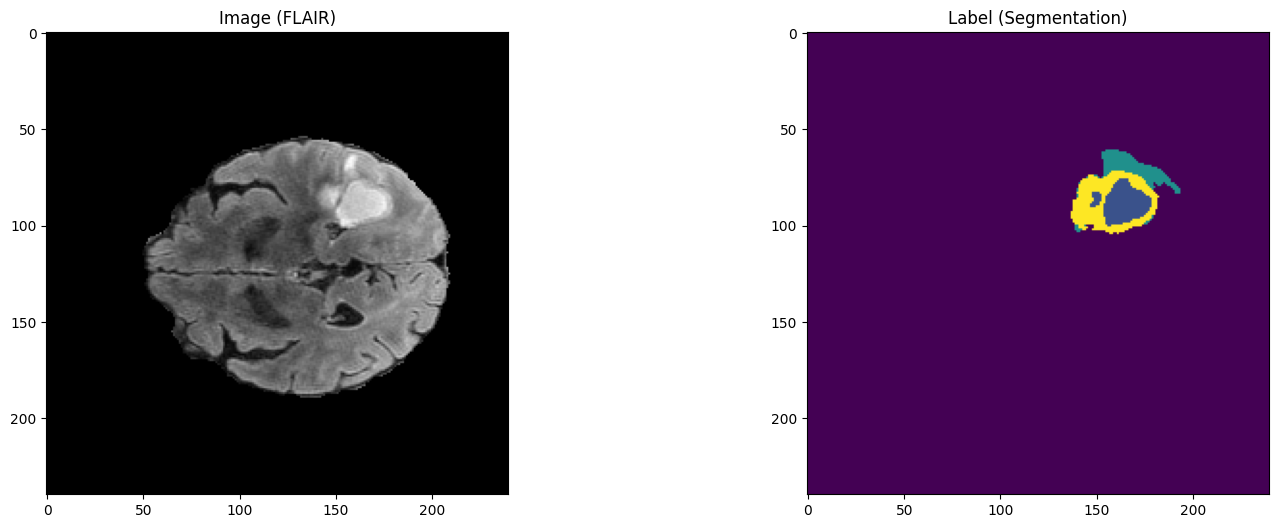

In [8]:
img_add = os.path.join(data_dir, "BraTS2021_00022/BraTS2021_00022_flair.nii.gz")
label_add = os.path.join(data_dir, "BraTS2021_00022/BraTS2021_00022_seg.nii.gz")

if not os.path.exists(img_add) or not os.path.exists(label_add):
    print("Error: One or both of the files not found!")
else:
    img = nib.load(img_add).get_fdata()
    label = nib.load(label_add).get_fdata()

    print(f"Image shape: {img.shape}, Label shape: {label.shape}")

    plt.figure("image", (18, 6))
    plt.subplot(1, 2, 1)
    plt.title("Image (FLAIR)")
    plt.imshow(img[:, :, img.shape[2] // 2], cmap="gray")  # Show middle slice
    plt.subplot(1, 2, 2)
    plt.title("Label (Segmentation)")
    plt.imshow(label[:, :, label.shape[2] // 2])
    plt.show()

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 2

# Reduce model size
model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=24,
    use_checkpoint=True,
).to(device)





monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


In [10]:
import torch.nn.functional as F 

In [ ]:
"""import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import gc
import numpy as np
import math

def visualize_attention_maps(model, test_loader, device='cpu'):
    model.eval()

    for batch_data in test_loader:
        image = batch_data["image"].to(device)

        _, c, h, w, d = image.shape
        print(f"Original image shape: {image.shape}")

        new_h = ((h + 31) // 32) * 32
        new_w = ((w + 31) // 32) * 32
        new_d = ((d + 31) // 32) * 32

        print(f"Resizing to: [{new_h}, {new_w}, {new_d}]")

        resized_image = F.interpolate(
            image,
            size=[new_h, new_w, new_d],
            mode='trilinear',
            align_corners=False
        )

        print(f"Resized image shape: {resized_image.shape}")

        slice_idx = d // 2
        original_slice = image[0, 0, :, :, slice_idx].detach().cpu().numpy()

        attention_maps = []

        def hook_fn(module, input, output):
            # For SwinUNETR, we need to handle different output formats
            if isinstance(output, tuple):
                attn = output[1].detach().cpu()  # Some models return (output, attention)
            else:
                attn = output.detach().cpu()
                
            print(f"Attention map shape: {attn.shape}")
            print(f"Attention map min: {attn.min()}, max: {attn.max()}")
            attention_maps.append(attn)

        hooks = []
        target_layers = []

        # Find suitable attention layers
        for name, module in model.named_modules():
            if "attn" in name and "blocks" in name:
                target_layers.append((name, module))
                hook = module.register_forward_hook(hook_fn)
                hooks.append(hook)
                # Just get the first attention layer for now
                break

        if not target_layers:
            print("No suitable attention layer found")
            return

        try:
            with torch.no_grad():
                _ = model(resized_image)

            for hook in hooks:
                hook.remove()

            if attention_maps:
                # Get the first attention map
                attn = attention_maps[0]
                
                # Handle the specific shape from your model
                # Shape is [4332, 343, 24] - likely [batch*windows, seq_len, num_heads]
                # We'll take the mean across heads
                attn_mean = attn.mean(dim=-1).numpy()  # [4332, 343]
                print(f"Attention map after mean across heads: {attn_mean.shape}")
                
                # For 3D data, we need to extract a meaningful 2D representation
                # Let's determine window size and patch size based on the dimensions
                
                # Assuming window size is 7x7x7 for SwinUNETR (common default)
                window_size = 7
                
                # Calculate the approximate feature map dimensions for one slice
                feat_h = h // 4  # Typical patch size is 4x4x4
                feat_w = w // 4
                
                # Select windows from the middle depth slice
                windows_per_h = math.ceil(feat_h / window_size)
                windows_per_w = math.ceil(feat_w / window_size)
                mid_slice_windows = windows_per_h * windows_per_w
                
                # We'll take windows from approximately the middle slice
                # This is a heuristic and might need adjustment
                middle_window_index = len(attn_mean) // 2
                start_idx = max(0, middle_window_index - mid_slice_windows // 2)
                end_idx = min(len(attn_mean), start_idx + mid_slice_windows)
                
                # Take a subset of windows for visualization
                selected_windows = attn_mean[start_idx:end_idx]
                print(f"Selected windows shape: {selected_windows.shape}")
                
                # Reshape to a grid for visualization
                grid_size = int(math.sqrt(len(selected_windows)))
                if grid_size**2 < len(selected_windows):
                    grid_size += 1
                    
                # Create a square grid that fits our windows
                grid = np.zeros((grid_size * window_size, grid_size * window_size))
                
                # Fill the grid with attention maps from each window
                for i, window_attn in enumerate(selected_windows):
                    if i >= grid_size**2:
                        break
                        
                    row = (i // grid_size) * window_size
                    col = (i % grid_size) * window_size
                    
                    # Reshape window attention to square and place in grid
                    window_vis = window_attn[:window_size**2].reshape(window_size, window_size)
                    grid[row:row+window_size, col:col+window_size] = window_vis
                
                # Resize to match original image dimensions
                resized_attn = cv2.resize(grid, (w, h), interpolation=cv2.INTER_LINEAR)
                
                # Normalize for visualization
                normalized_attn = (resized_attn - resized_attn.min()) / (resized_attn.max() - resized_attn.min() + 1e-8)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original Image")
                plt.imshow(original_slice, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Attention Map")
                plt.imshow(normalized_attn, cmap='viridis')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Overlay")
                plt.imshow(original_slice, cmap='gray')
                plt.imshow(normalized_attn, cmap='viridis', alpha=0.5)
                plt.axis('off')

                plt.tight_layout()
                plt.savefig('attention_visualization.png')  # Save the figure
                plt.show()

                plt.close()
            else:
                print("No attention maps captured")

        except Exception as e:
            print(f"Error during visualization: {str(e)}")
            import traceback
            traceback.print_exc()

        gc.collect()
        break"""

In [11]:
# Enable gradient checkpointing
torch.cuda.empty_cache()
model.use_checkpoint = True

# Modify the data loader to use less memory
train_loader, val_loader = get_loader(
    batch_size=batch_size,
    data_dir=data_dir,
    json_list=json_list,
    fold=fold,
    roi=roi
)

In [12]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [13]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()

    with tqdm(loader, desc=f"Epoch {epoch + 1}/{max_epochs}", unit="batch") as tepoch:
        for idx, batch_data in enumerate(tepoch):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model(data)
            loss = loss_func(logits, target)
            loss.backward()

            optimizer.step()
            run_loss.update(loss.item(), n=batch_size)

            tepoch.set_postfix(loss=run_loss.avg)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [14]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

In [15]:
case_num = "00206"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

def calculate_pad_size(original_size):
    return [(((s + 31) // 32) * 32) - s for s in original_size]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.SpatialPadd(
            keys=["image", "label"],
            spatial_size=(256, 256, 160)  # Padded to dimensions divisible by 32
        ),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [16]:
current_dir = os.getcwd()
checkpoint = torch.load(os.path.join(current_dir, "final_model.pt"), weights_only=False)
model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


In [ ]:
print(model)

In [17]:
corrected_data = []
for item in test_loader.dataset.data:
    item["image"] = [img_path.replace("TrainingData\\TrainingData", "TrainingData") for img_path in item["image"]]
    corrected_data.append(item)

test_loader.dataset.data = corrected_data


In [23]:
for batch_data in test_loader.dataset.data:
    print(batch_data["image"])

['./TrainingData\\BraTS2021_00206/BraTS2021_00206_flair.nii.gz', './TrainingData\\BraTS2021_00206/BraTS2021_00206_t1ce.nii.gz', './TrainingData\\BraTS2021_00206/BraTS2021_00206_t1.nii.gz', './TrainingData\\BraTS2021_00206/BraTS2021_00206_t2.nii.gz']


In [19]:
import torch
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.7, device=0)

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def visualize_swinunetr_attention(model, image_data, slice_idx=None):
    """
    Specialized function to visualize attention for SwinUNETR model.
    
    Args:
        model: SwinUNETR model
        image_data: Input image tensor [B, C, H, W, D]
        slice_idx: Which slice to visualize (None for middle slice)
    """
    b, c, h, w, d = image_data.shape
    if slice_idx is None:
        slice_idx = d // 2  # Default to middle slice
    
    # Get original image slice for visualization
    original_slice = image_data[0, 0, :, :, slice_idx].detach().cpu().numpy()
    
    # Custom hook for SwinUNETR's WindowAttention module
    attention_maps = []
    
    def attention_hook(module, input, output):
        """Special hook for WindowAttention in SwinUNETR"""
        # In SwinUNETR, WindowAttention typically returns x as output
        # But we need to capture the attention weights during computation
        try:
            # Try to extract QKV
            qkv = module.qkv(input[0])  # [B, N, 3*C]
            b, n, _ = qkv.shape
            qkv = qkv.reshape(b, n, 3, module.num_heads, -1).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]  # Each is [B, num_heads, N, C//num_heads]
            
            # Calculate attention scores
            attn = (q @ k.transpose(-2, -1)) * module.scale  # [B, num_heads, N, N]
            
            # Apply softmax
            attn = attn.softmax(dim=-1)  # [B, num_heads, N, N]
            
            attention_maps.append(attn.detach().cpu())
            return output
        except Exception as e:
            print(f"Error in attention hook: {e}")
            return output
    
    # Register hooks for Window Attention modules
    handles = []
    for name, module in model.named_modules():
        if "WindowAttention" in module.__class__.__name__ or "windowattention" in module.__class__.__name__.lower():
            handles.append(module.register_forward_hook(attention_hook))
    
    # Forward pass to collect attention maps
    with torch.no_grad():
        _ = model(image_data)
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    print(f"Collected {len(attention_maps)} attention maps")
    
    if not attention_maps:
        print("No attention maps were collected. Trying alternative approach...")
        # Alternative: use direct forward hooks on specific layers
        return None
    
    # Process the collected attention maps
    # For visualization, we'll use the attention from the first window attention module
    attn = attention_maps[0]  # Shape: [B, num_heads, N, N]
    
    # Average over heads and batches
    attn = attn.mean(dim=1)[0]  # Shape: [N, N]
    
    # For Swin Transformer, N = window_size^2 where window_size is typically 7
    window_size = int(np.sqrt(attn.shape[0] + 0.5))
    print(f"Detected window size: {window_size}")
    
    # Get attention from each token to all others
    # For simplicity, we'll use attention from the center token
    center_idx = attn.shape[0] // 2
    token_attn = attn[center_idx]
    
    # Reshape to 2D grid (assuming it's a square window)
    try:
        attention_2d = token_attn.reshape(window_size, window_size).numpy()
    except:
        print(f"Reshaping failed. Token attention shape: {token_attn.shape}")
        # Fall back to using the average attention across all tokens
        attention_2d = attn.mean(dim=0).reshape(window_size, window_size).numpy()
    
    # Upsample to match the slice dimensions
    attention_2d = torch.tensor(attention_2d).unsqueeze(0).unsqueeze(0)
    attention_2d = F.interpolate(
        attention_2d, 
        size=(h, w), 
        mode='bilinear', 
        align_corners=False
    ).squeeze().numpy()
    
    # Normalize for visualization
    attention_2d = (attention_2d - attention_2d.min()) / (attention_2d.max() - attention_2d.min() + 1e-8)
    
    # Apply Gaussian smoothing for better visualization
    attention_2d_smooth = gaussian_filter(attention_2d, sigma=5)
    
    # Create visualization
    plt.figure(figsize=(18, 6))
    
    # Plot original image
    plt.subplot(131)
    plt.title("Original Brain MRI")
    plt.imshow(original_slice, cmap='gray')
    plt.axis('off')
    
    # Plot attention map
    plt.subplot(132)
    plt.title("Attention Map")
    plt.imshow(attention_2d_smooth, cmap='hot')
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(133)
    plt.title("Attention Overlay")
    plt.imshow(original_slice, cmap='gray')
    plt.imshow(attention_2d_smooth, cmap='hot', alpha=0.6)
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('swinunetr_attention.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return attention_2d_smooth

# Alternative implementation that directly modifies the WindowAttention module
def visualize_with_module_modification(model, image_data, slice_idx=None):
    """
    Visualize attention by temporarily modifying the SwinUNETR's attention module
    """
    b, c, h, w, d = image_data.shape
    if slice_idx is None:
        slice_idx = d // 2
    
    # Get original image slice for visualization
    original_slice = image_data[0, 0, :, :, slice_idx].detach().cpu().numpy()
    
    # Find all WindowAttention modules
    attention_modules = []
    for name, module in model.named_modules():
        if "WindowAttention" in module.__class__.__name__ or "windowattention" in module.__class__.__name__.lower():
            attention_modules.append(module)
    
    if not attention_modules:
        print("No WindowAttention modules found")
        return None
    
    # Create a temporary forward function to capture attention
    original_forwards = []
    attention_outputs = []
    
    for idx, module in enumerate(attention_modules):
        # Save original forward function
        original_forwards.append(module.forward)
        
        # Create a temporary function that captures attention
        def make_new_forward(original_forward, module_idx):
            def new_forward(self, x, mask=None):
                # Apply original QKV projection
                B_, N, C = x.shape
                qkv = self.qkv(x)
                qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
                q, k, v = qkv[0], qkv[1], qkv[2]
                
                # Calculate attention
                attn = (q @ k.transpose(-2, -1)) * self.scale
                
                if mask is not None:
                    attn = attn.view(B_ // mask.shape[0], mask.shape[0], self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
                    attn = attn.view(-1, self.num_heads, N, N)
                
                attn = self.softmax(attn)
                
                # Store attention map
                attention_outputs.append(attn.detach().cpu())
                
                # Continue with original forward pass
                attn = self.attn_drop(attn)
                x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
                x = self.proj(x)
                x = self.proj_drop(x)
                return x
            
            return new_forward
        
        # Replace forward method
        module.forward = make_new_forward(module.forward, idx).__get__(module, module.__class__)
    
    # Forward pass
    with torch.no_grad():
        try:
            _ = model(image_data)
        except Exception as e:
            print(f"Error during forward pass: {e}")
    
    # Restore original forward methods
    for module, original_forward in zip(attention_modules, original_forwards):
        module.forward = original_forward.__get__(module, module.__class__)
    
    print(f"Collected {len(attention_outputs)} attention maps")
    
    if not attention_outputs:
        print("Failed to collect attention maps")
        return None
    
    # Process collected attentions - use the first layer's attention for simplicity
    attn = attention_outputs[0]  # Shape [B*windows, heads, window_size^2, window_size^2]
    
    # Average over heads
    attn = attn.mean(dim=1)  # [B*windows, window_size^2, window_size^2]
    
    # Extract a single window's attention (first window)
    window_attn = attn[0]  # [window_size^2, window_size^2]
    
    # Estimate window size
    window_size = int(np.sqrt(window_attn.shape[0] + 0.5))
    
    # Get attention from center token
    center_idx = window_attn.shape[0] // 2
    center_attn = window_attn[center_idx]
    
    # Reshape to 2D grid
    try:
        attention_2d = center_attn.reshape(window_size, window_size).numpy()
    except:
        print(f"Reshaping failed. Center attention shape: {center_attn.shape}")
        attention_2d = window_attn.mean(dim=0).reshape(window_size, window_size).numpy()
    
    # Resize to match image dimensions
    attention_2d = torch.tensor(attention_2d).unsqueeze(0).unsqueeze(0)
    attention_2d = F.interpolate(
        attention_2d, 
        size=(h, w), 
        mode='bilinear', 
        align_corners=False
    ).squeeze().numpy()
    
    # Normalize and smooth
    attention_2d = (attention_2d - attention_2d.min()) / (attention_2d.max() - attention_2d.min() + 1e-8)
    attention_2d_smooth = gaussian_filter(attention_2d, sigma=5)
    
    # Create visualization
    plt.figure(figsize=(18, 6))
    
    # Plot original image
    plt.subplot(131)
    plt.title("Original Brain MRI")
    plt.imshow(original_slice, cmap='gray')
    plt.axis('off')
    
    # Plot attention map
    plt.subplot(132)
    plt.title("Attention Map")
    plt.imshow(attention_2d_smooth, cmap='hot')
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(133)
    plt.title("Attention Overlay")
    plt.imshow(original_slice, cmap='gray')
    plt.imshow(attention_2d_smooth, cmap='hot', alpha=0.6)
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('swinunetr_direct_attention.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return attention_2d_smooth

# Extract features for gradient-based attention
def grad_cam_for_swinunetr(model, image_data, target_layer=None, slice_idx=None):
    """
    Implement Grad-CAM for SwinUNETR as an alternative to attention visualization
    """
    b, c, h, w, d = image_data.shape
    if slice_idx is None:
        slice_idx = d // 2
    
    # Get original image slice
    original_slice = image_data[0, 0, :, :, slice_idx].detach().cpu().numpy()
    
    # Find a suitable feature layer if not specified
    if target_layer is None:
        # Find a convolution or projection layer in the decoder path
        for name, module in model.named_modules():
            if ("conv" in name or "proj" in name) and "encoder" not in name:
                target_layer = module
                target_layer_name = name
                break
    
    if target_layer is None:
        print("No suitable target layer found")
        return None
    
    # Register hooks for Grad-CAM
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output.detach())
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())
    
    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    model.zero_grad()
    image_data.requires_grad = True
    
    # For simplicity we'll use the model's output directly
    # In a real segmentation task, we'd use a specific class prediction
    output = model(image_data)
    
    # Use sum of output as loss for backward pass
    loss = output.sum()
    loss.backward()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    # Process activations and gradients
    if not activations or not gradients:
        print("Failed to capture activations or gradients")
        return None
    
    # Get activations and gradients
    activation = activations[0]
    gradient = gradients[0]
    
    # Reshape if needed for 3D data
    if len(activation.shape) == 5:  # [B, C, D, H, W]
        # Get the slice of interest
        activation_slice = activation[0, :, slice_idx].detach()
        gradient_slice = gradient[0, :, slice_idx].detach()
    else:
        activation_slice = activation[0].detach()
        gradient_slice = gradient[0].detach()
    
    # Calculate channel-wise weights
    weights = gradient_slice.mean(dim=(1, 2))
    
    # Create weighted combination of activation maps
    cam = torch.zeros(activation_slice.shape[1:]).to(activation_slice.device)
    for i, w in enumerate(weights):
        cam += w * activation_slice[i]
    
    # Apply ReLU
    cam = F.relu(cam)
    
    # Convert to numpy and resize
    cam = cam.cpu().numpy()
    cam = cv2.resize(cam, (w, h))
    
    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    
    # Apply Gaussian smoothing
    cam_smooth = gaussian_filter(cam, sigma=2)
    
    # Create visualization
    plt.figure(figsize=(18, 6))
    
    # Plot original image
    plt.subplot(131)
    plt.title("Original Brain MRI")
    plt.imshow(original_slice, cmap='gray')
    plt.axis('off')
    
    # Plot attention map
    plt.subplot(132)
    plt.title("Grad-CAM Activation")
    plt.imshow(cam_smooth, cmap='hot')
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(133)
    plt.title("Grad-CAM Overlay")
    plt.imshow(original_slice, cmap='gray')
    plt.imshow(cam_smooth, cmap='hot', alpha=0.6)
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('swinunetr_gradcam.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cam_smooth

# Function to run all visualization methods
def visualize_all_methods(model, test_loader):
    for batch_data in test_loader:
        image = batch_data["image"]
        
        print("Method 1: Standard Attention Visualization")
        try:
            attention_map = visualize_swinunetr_attention(model, image)
        except Exception as e:
            print(f"Method 1 failed: {e}")
        
        print("\nMethod 2: Module Modification Approach")
        try:
            attention_map2 = visualize_with_module_modification(model, image)
        except Exception as e:
            print(f"Method 2 failed: {e}")
        
        print("\nMethod 3: Grad-CAM Alternative")
        try:
            import cv2
            gradcam_map = grad_cam_for_swinunetr(model, image)
        except Exception as e:
            print(f"Method 3 failed: {e}")
        
        break

# Usage
# visualize_all_methods(model, test_loader)

In [22]:
model.to('cpu')  # Move model to CPU for visualization
import cv2  # Make sure OpenCV is installed
for batch in test_loader:
    # Use the first batch
    first_batch = batch
    break

# Now use the image from the first batch
gradcam_map = grad_cam_for_swinunetr(model, first_batch["image"])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type


In [20]:
model.to('cpu')
visualize_attention_maps(model, test_loader, device='cpu')

NameError: name 'visualize_attention_maps' is not defined